In [12]:
import os
import pickle
import torch
import numpy as np
import matplotlib.pyplot as plt

In [13]:
with open('./pickle_files/embeddings_inds_test_imdb.pkl', 'rb') as f:
    embeddings_imdb_test = pickle.load(f)

with open('./pickle_files/logits_inds_test_imdb.pkl', 'rb') as f:
    logits_imdb_test = pickle.load(f)


In [14]:
with open('./pickle_files/embeddings_inds_train_imdb.pkl', 'rb') as f:
    embeddings_imdb_train = pickle.load(f)

with open('./pickle_files/logits_inds_train_imdb.pkl', 'rb') as f:
    logits_imdb_train = pickle.load(f)

In [15]:
ood_embeddings = []
ood_logits = []
ood_dict = {}

for filename in [el for el in os.listdir('./pickle_files') if el.startswith('embeddings_ood_test_')]:

    ds_name = filename.split('_')[-1].split('.')[0]
    values = {}

    with open('./pickle_files/'+filename, 'rb') as f:
        embeddings = pickle.load(f)
    ood_embeddings += embeddings

    values['embeddings'] = embeddings

    with open(f'./pickle_files/logits_ood_test_{ds_name}.pkl', 'rb') as f:
        logits = pickle.load(f)
    ood_logits += logits

    values['logits'] = logits

    ood_dict[ds_name] = values 

In [16]:
embeddings_imdb_test = torch.cat(embeddings_imdb_test).numpy()
logits_imdb_test = torch.cat(logits_imdb_test).numpy()

In [17]:
def get_predicted_indices(l, logits):
    return np.where(np.argmax(logits, axis=-1)==l)

In [18]:
embeddings_imdb_test_distrib  = {l: embeddings_imdb_test[get_predicted_indices(l, logits_imdb_test)] for l in range(logits_imdb_test.shape[1])}
logit_test_distrib  = {l: logits_imdb_test[get_predicted_indices(l, logits_imdb_test)] for l in range(logits_imdb_test.shape[1])}

In [19]:
embeddings_imdb_train = torch.cat(embeddings_imdb_train).numpy()
logits_imdb_train = torch.cat(logits_imdb_train).numpy()

embeddings_imdb_train_distrib  = {l: embeddings_imdb_train[get_predicted_indices(l, logits_imdb_train)] for l in range(logits_imdb_train.shape[1])}
logit_train_distrib  = {l: logits_imdb_train[get_predicted_indices(l, logits_imdb_train)] for l in range(logits_imdb_train.shape[1])}


In [20]:
# Aggregation per ood dataset
for ds_dict in ood_dict.values():
    for k, v in ds_dict.items():
        ds_dict[k] = torch.cat(v).numpy()
        
    ds_dict['ood_embeddings_distrib']  = {l: ds_dict['embeddings'][get_predicted_indices(l, ds_dict['logits'])] for l in range(ds_dict['logits'].shape[1])}
    ds_dict['ood_logits_distrib']  = {l: ds_dict['logits'][get_predicted_indices(l, ds_dict['logits'])] for l in range(ds_dict['logits'].shape[1])}

In [21]:
from ood_detector import OODDetector
from sklearn.metrics import average_precision_score, roc_auc_score
import seaborn as sns

In [28]:
from utils.my_utils import softmax
def plot_score_distrib_non_prediction_dependant(metric):

    clf = OODDetector(
            similarity_measure=metric,
            base_distrib=logits_imdb_train,
            T=10,
         ).fit() 

    scores=[]
    weights=[]
    for ds_name,ood_ds in ood_dict.items():
        y_score_tot = []
        y_true_tot = []
        score_per_ds = []

        y_true = np.concatenate((np.ones(ood_ds['logits'].shape[0]), np.zeros(logits_imdb_test.shape[0])))
        X = np.concatenate((ood_ds['logits'] ,logits_imdb_test))
        y_score = clf.predict_proba(X).flatten()
        auc_score = roc_auc_score(y_true=y_true, y_score=y_score)
        aupr = average_precision_score(y_true=y_true, y_score=y_score)
        scores.append([auc_score, aupr])
        weights.append(len(y_true))



        bins_width = (np.histogram(y_score[y_true==1])[1][3]-np.histogram(y_score[y_true==1])[1][2])/2
        sns.histplot(y_score[y_true==0], label='IN-DS', kde=True, stat='probability', color='skyblue', binwidth=bins_width, line_kws={"lw":3})
        sns.histplot(y_score[y_true==1], label='OOD-DS', kde=True, stat='probability', color='red', binwidth=bins_width, line_kws={"lw":3})
        avg = scores[-1]
        plt.title(f"auroc : {avg[0]:.3f}, aupr : {avg[1]:.3f}")

        plt.suptitle(ds_name + f' - {clf.similarity_measure}')
        plt.legend()
        plt.savefig(f'./figures/{clf.similarity_measure}_{ds_name}.png')
        plt.show()

    scores, weights = np.array(scores), np.array(weights)/(np.sum(weights))
    print(f" Weighted mean {scores.T@weights}")
    print(f"Mean {np.mean(scores, axis=0)}")
    

In [35]:
def plot_score_distrib_prediction_dependant(metric):

    clfs = { i : OODDetector(
            similarity_measure=metric,
            base_distrib=embeddings_imdb_train_distrib[i],
            T=10,
         ).fit() for i in (0,1) }

    scores=[]
    weights=[]
    for ds_name,ood_ds in ood_dict.items():
        y_score_tot = []
        y_true_tot = []
        score_per_ds = []
        
        for i in (0,1):
            
            clf= clfs[i]
            y_true = np.concatenate((np.ones(ood_ds['ood_embeddings_distrib'][i].shape[0]), np.zeros(embeddings_imdb_test_distrib[i].shape[0])))
            X = np.concatenate((ood_ds['ood_embeddings_distrib'][i] ,embeddings_imdb_test_distrib[i]))
            # aggregate with mean embeddings
            X = np.mean(X, axis=-1)
            y_score = clf.predict_proba(X).flatten()
            auc_score = roc_auc_score(y_true=y_true, y_score=y_score)
            aupr = average_precision_score(y_true=y_true, y_score=y_score)
            scores.append([auc_score, aupr])
            weights.append(len(y_true))
            score_per_ds.append([auc_score, aupr])
            y_score_tot.append((y_score - np.mean(y_score))/np.std(y_score))
            y_true_tot.append(y_true)
        
        y_score_tot = np.concatenate(y_score_tot)
        y_true_tot = np.concatenate(y_true_tot)



        bins_width = (np.histogram(y_score[y_true==1])[1][3]-np.histogram(y_score[y_true==1])[1][2])/2
        sns.histplot(y_score[y_true==0], label='IN-DS', kde=True, stat='probability', color='skyblue', binwidth=bins_width, line_kws={"lw":3})
        sns.histplot(y_score[y_true==1], label='OOD-DS', kde=True, stat='probability', color='red', binwidth=bins_width, line_kws={"lw":3})
        avg = scores[-1]
        plt.title(f"auroc : {avg[0]:.3f}, aupr : {avg[1]:.3f}")

        plt.suptitle(ds_name + f' - {clf.similarity_measure}')
        plt.legend()
        plt.savefig(f'./figures/{clf.similarity_measure}_{ds_name}.png')
        plt.show()

    scores, weights = np.array(scores), np.array(weights)/(np.sum(weights))
    print(f" Weighted mean {scores.T@weights}")
    print(f"Mean {np.mean(scores, axis=0)}")
    

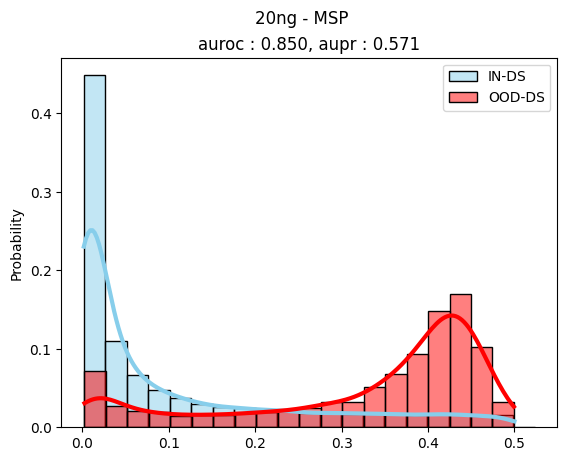

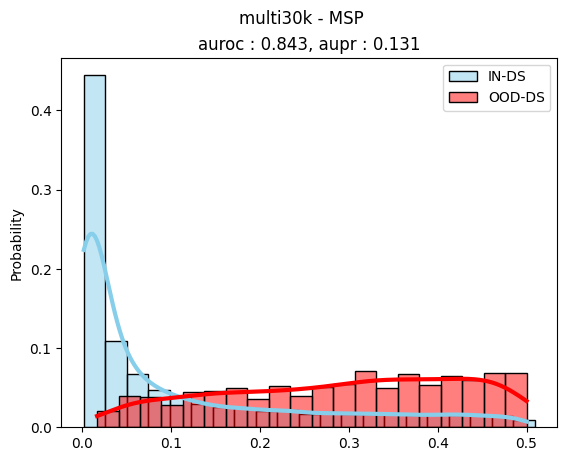

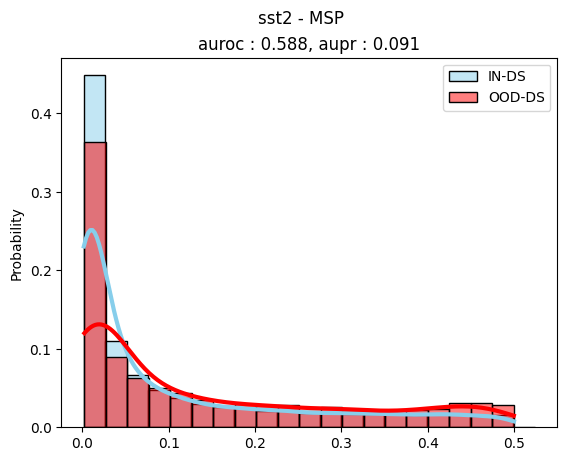

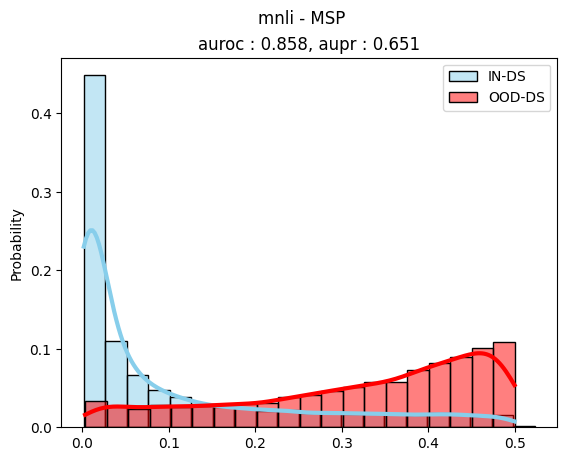

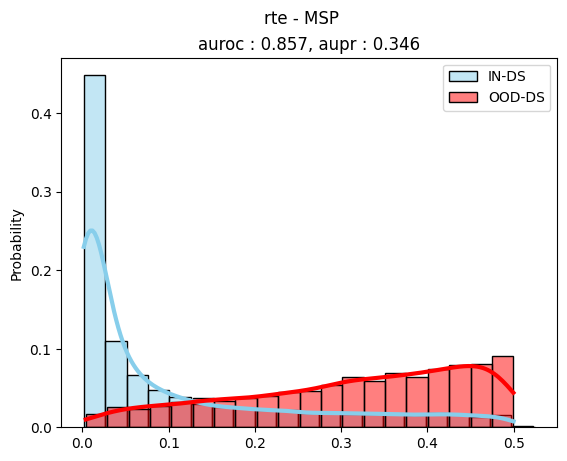

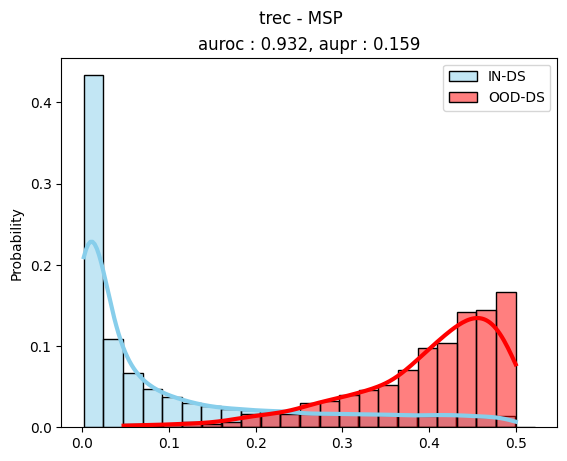

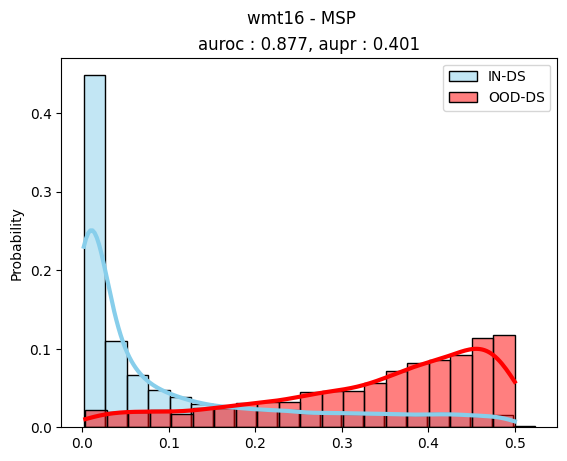

 Weighted mean [0.83083604 0.35708994]
Mean [0.82937867 0.33551427]


In [30]:
plot_score_distrib_non_prediction_dependant('MSP')

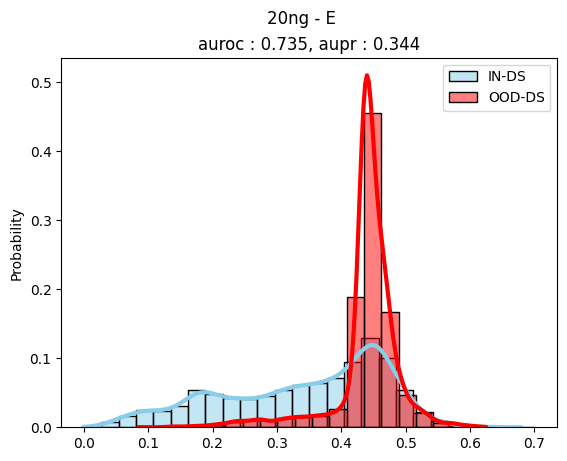

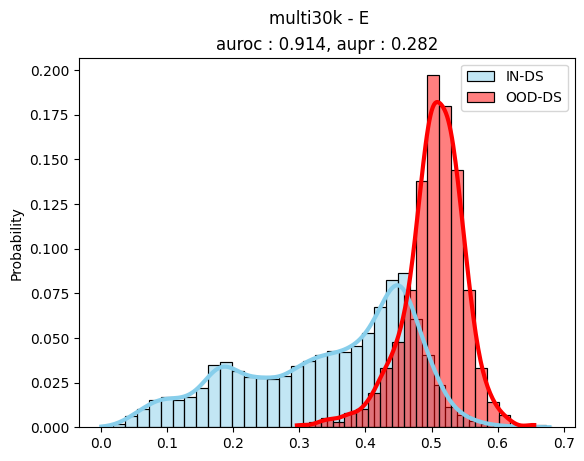

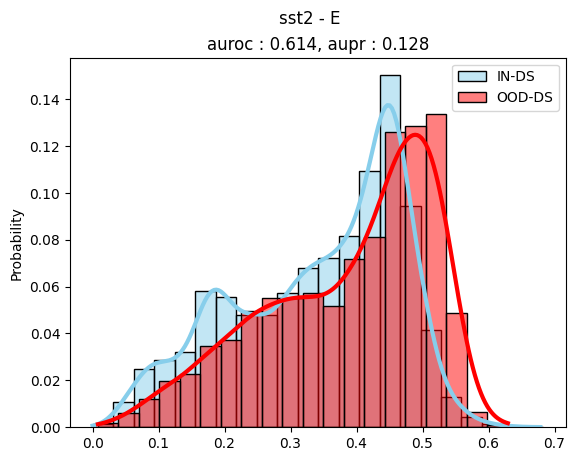

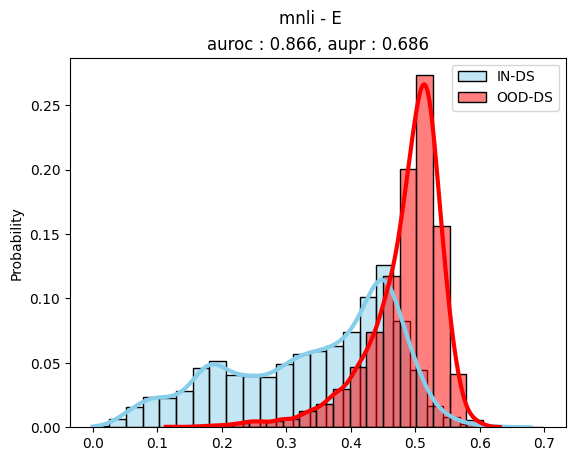

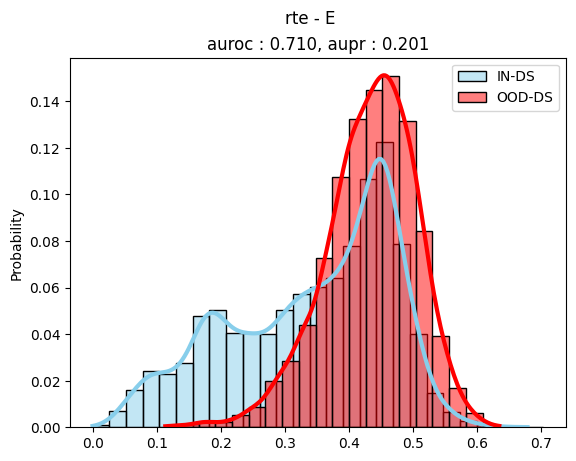

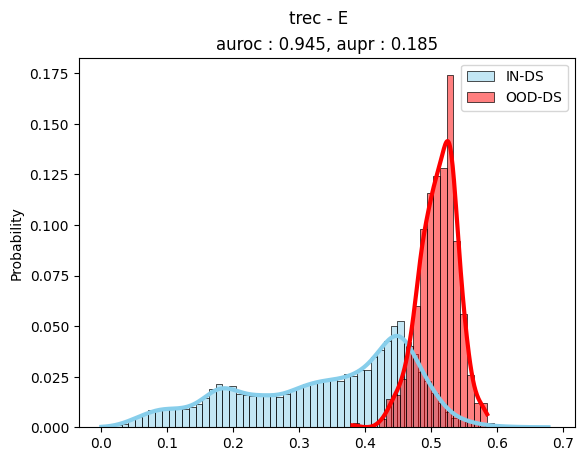

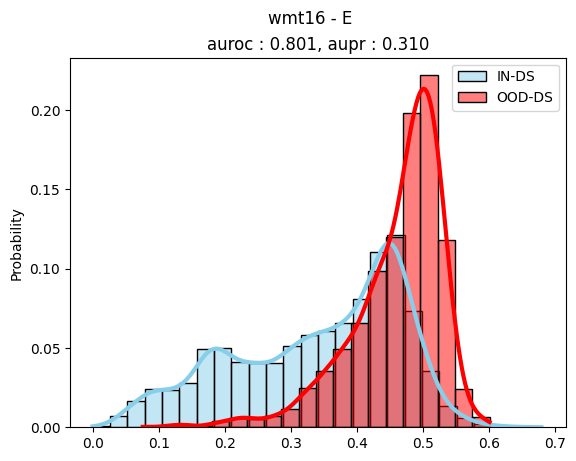

 Weighted mean [0.79685326 0.32169242]
Mean [0.79787859 0.3052435 ]


In [31]:
plot_score_distrib_non_prediction_dependant('E')

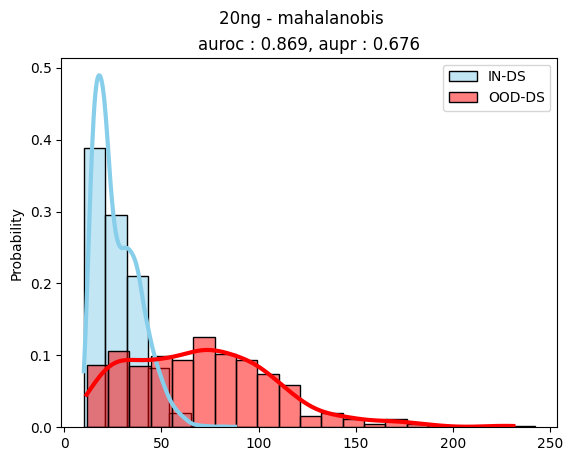

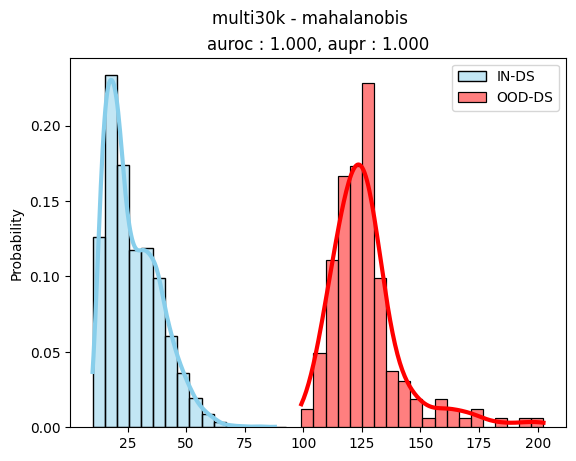

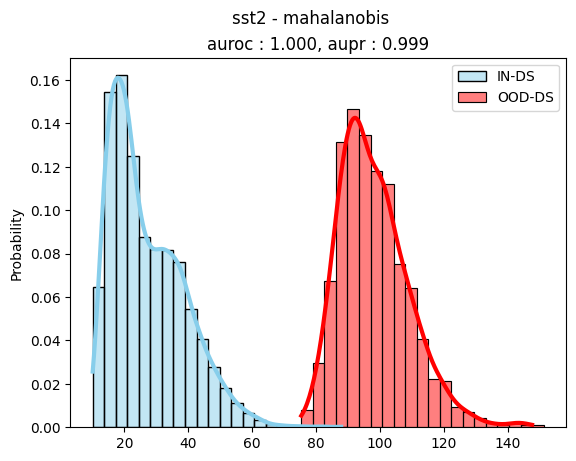

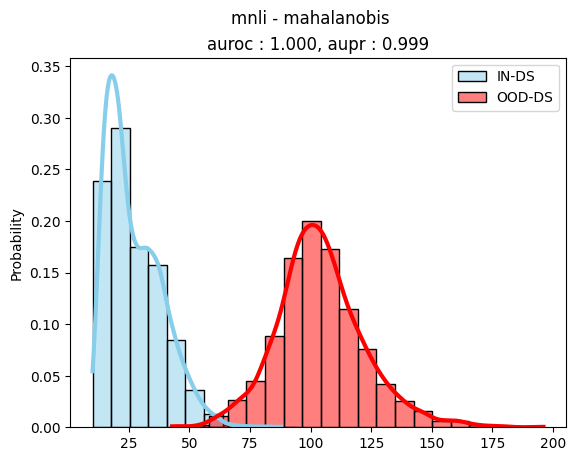

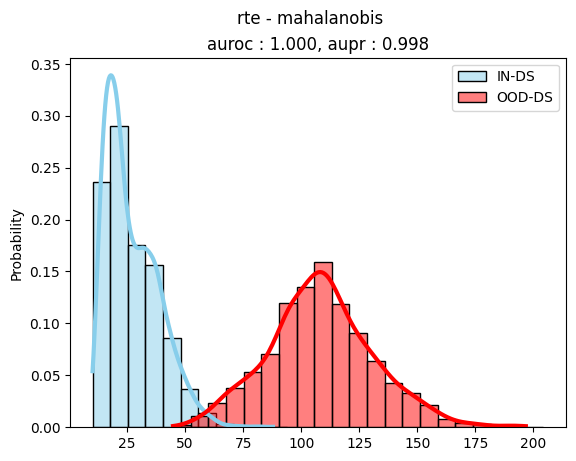

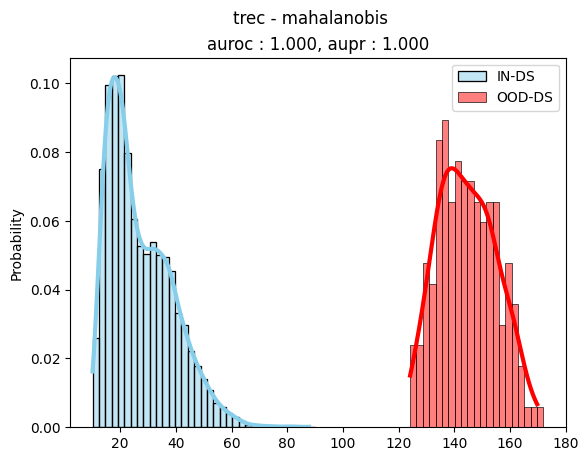

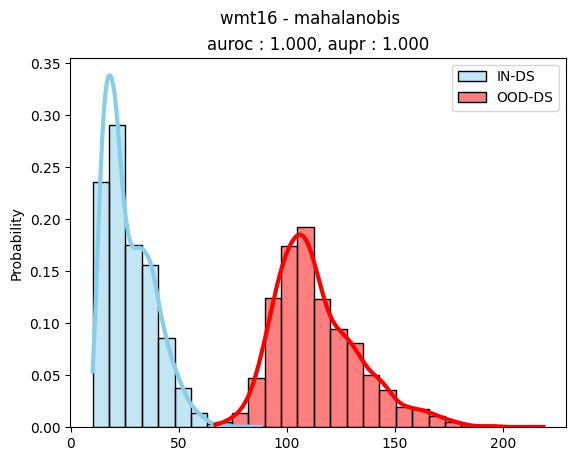

 Weighted mean [0.94186506 0.92502557]
Mean [0.95544238 0.93748568]


In [36]:
plot_score_distrib_prediction_dependant('mahalanobis')

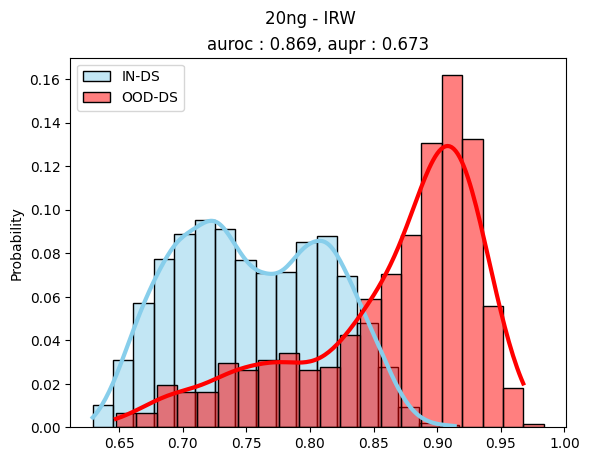

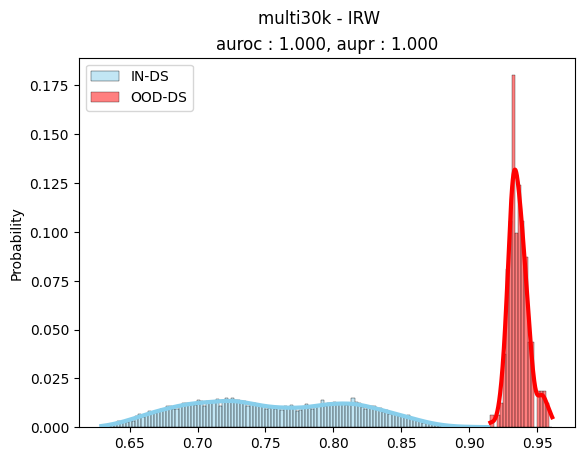

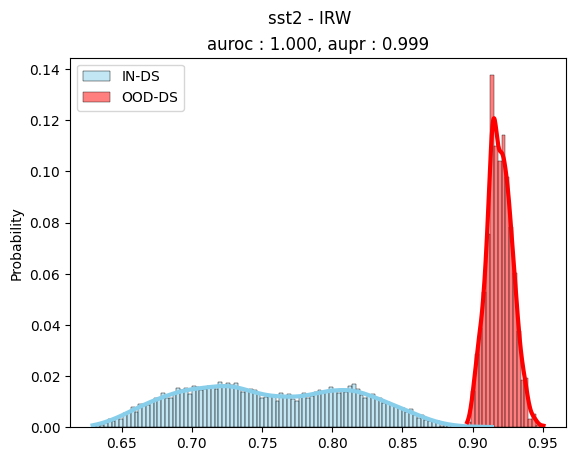

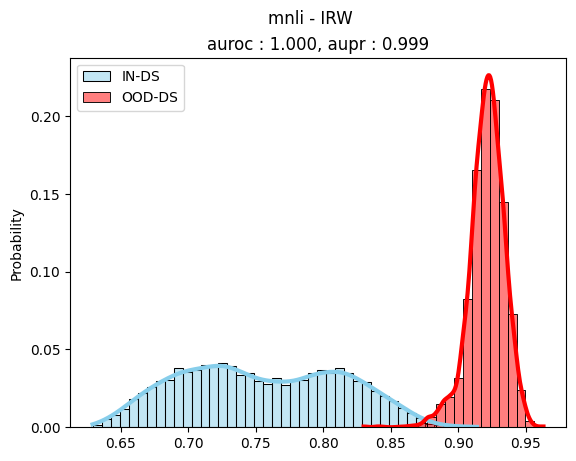

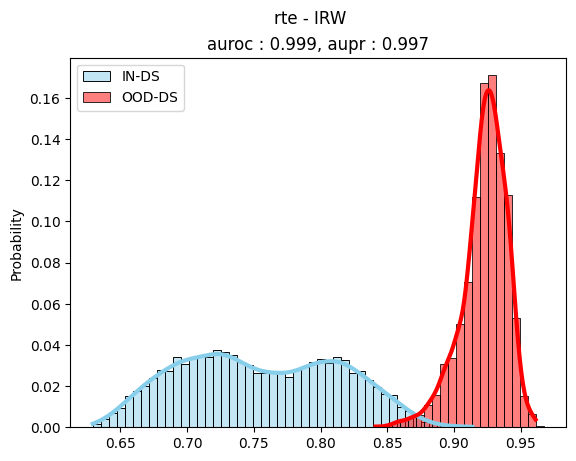

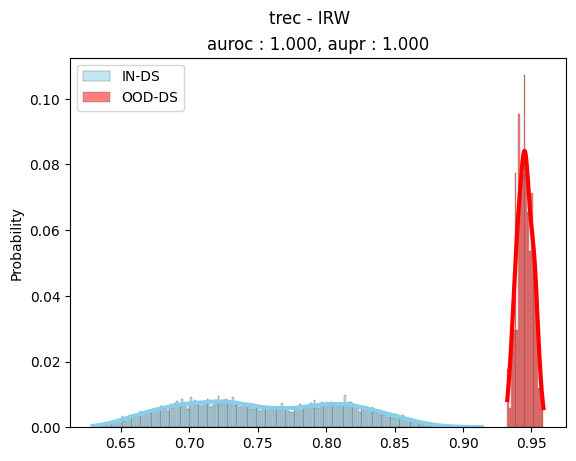

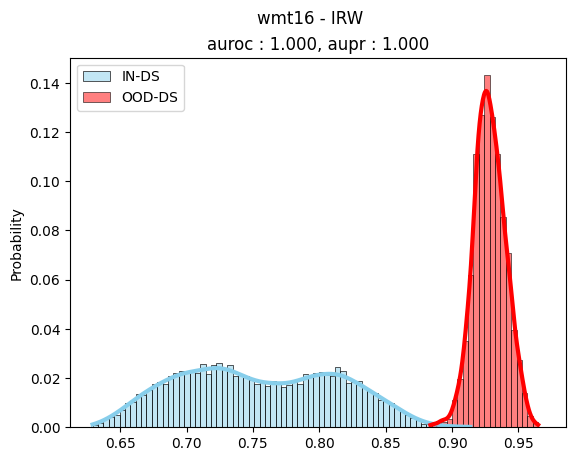

 Weighted mean [0.9417671  0.92469437]
Mean [0.95536362 0.93711992]


In [37]:
plot_score_distrib_prediction_dependant('IRW')